In [1]:
import pandas as pd
import numpy as np
from azure.ai.ml import MLClient
from azure.identity import DefaultAzureCredential

file_name = "cncAffluence"
version="1"

ml_client = MLClient(
    credential=DefaultAzureCredential(),
    subscription_id="72eb7803-e874-44cb-b6d9-33f2fa3eb88c",
    resource_group_name="vpoutotrg",
    workspace_name="mlstudio-groupe4"
)

data_asset = ml_client.data.get(file_name, version=version)

df = pd.read_parquet(data_asset.path)

df.head()

Overriding of current TracerProvider is not allowed
Overriding of current LoggerProvider is not allowed
Overriding of current MeterProvider is not allowed
Attempting to instrument while already instrumented
Attempting to instrument while already instrumented
Attempting to instrument while already instrumented
Attempting to instrument while already instrumented
Attempting to instrument while already instrumented
Overriding of current TracerProvider is not allowed
Overriding of current LoggerProvider is not allowed
Overriding of current MeterProvider is not allowed
Attempting to instrument while already instrumented
Attempting to instrument while already instrumented
Attempting to instrument while already instrumented
Attempting to instrument while already instrumented
Attempting to instrument while already instrumented


,Date Article,Période,Année Courante,Année Précédente,Évolution (%)
0,2025-04-03,janvier,13.81,13.71,+0.8
1,2025-04-03,février,14.51,15.06,-3.7
2,2025-04-03,mars,12.53,15.19,-17.5
3,2025-04-03,trois premiers mois,40.85,43.96,-7.1
4,2025-04-03,année glissante (d’avril n-1 à mars n),178.41,175.79,+1.5


In [2]:
df['Date Article']= pd.to_datetime(df['Date Article'])


df = df.sort_values('Date Article', ascending=True)

In [3]:
df.head()

,Date Article,Période,Année Courante,Année Précédente,Évolution (%)
1499,2010-12-08,Juin,10.85,11.19,-3.1
1496,2010-12-08,Mars,18.67,17.75,+5.2
1497,2010-12-08,Avril,18.58,17.39,+6.8
1498,2010-12-08,Mai,15.95,14.94,+6.6
1500,2010-12-08,Juillet,18.39,20.88,-11.9


In [4]:
df.shape

(1526, 5)

In [5]:
fr_month = {
    'janvier', 'février', 'mars', 
    'avril', 'mai', 'juin', 
    'juillet', 'août', 'septembre', 
    'octobre', 'novembre', 'décembre'
}

def make_month(x):
    if x["Période"].lower() in fr_month:
        return x["Période"].lower() + " " + str(x["Date Article"].year)
    else:
        return np.nan

df['month'] = df.apply(make_month, axis=1)

In [6]:
df.dropna(inplace=True)

In [7]:
df.shape

(1032, 6)

In [8]:
df.drop('Date Article', axis=1, inplace=True)
df.drop('Période', axis=1, inplace=True)
df.drop('Évolution (%)', axis=1, inplace=True)

In [9]:
df.drop_duplicates(inplace=True)

In [10]:
df.head(10)

,Année Courante,Année Précédente,month
1499,10.85,11.19,juin 2010
1496,18.67,17.75,mars 2010
1497,18.58,17.39,avril 2010
1498,15.95,14.94,mai 2010
1500,18.39,20.88,juillet 2010
1501,17.51,15.06,août 2010
1502,10.67,10.49,septembre 2010
1503,18.54,15.75,octobre 2010
1504,19.27,20.94,novembre 2010
1495,20.48,19.05,février 2010


In [11]:
df2 = df.copy()
df2['Année Courante']=df['Année Précédente']

In [12]:
df2.drop('Année Précédente', axis=1, inplace=True)

In [13]:
def precedant_year(x):
    year = int(x[-4:])-1
    return x[:-4] + str(year)

df2['month'] = df2['month'].apply(lambda x : precedant_year(x))

In [14]:
df2.head()

,Année Courante,month
1499,11.19,juin 2009
1496,17.75,mars 2009
1497,17.39,avril 2009
1498,14.94,mai 2009
1500,20.88,juillet 2009


In [15]:
df.drop('Année Précédente', axis=1, inplace=True)
df = pd.concat([df,df2])

In [16]:
df

,Année Courante,month
1499,10.85,juin 2010
1496,18.67,mars 2010
1497,18.58,avril 2010
1498,15.95,mai 2010
1500,18.39,juillet 2010
...,...,...
99,13.71,janvier 2024
17,13.71,janvier 2024
18,15.08,février 2024
2,15.19,mars 2024


In [17]:
df_final = df.groupby(['month']).mean()

In [18]:
df_final.reset_index(inplace=True)

In [19]:
df_final

,month,Année Courante
0,août 2009,14.905000
1,août 2010,16.740000
2,août 2011,17.312000
3,août 2012,14.958571
4,août 2013,14.898571
...,...,...
179,septembre 2020,5.590000
180,septembre 2021,9.220000
181,septembre 2022,7.866000
182,septembre 2023,8.521429


In [20]:
mois_fr_to_en = {
    'janvier': 'January', 'février': 'February', 'mars': 'March', 
    'avril': 'April', 'mai': 'May', 'juin': 'June', 
    'juillet': 'July', 'août': 'August', 'septembre': 'September', 
    'octobre': 'October', 'novembre': 'November', 'décembre': 'December'
}

def convert_fr_date(date_str):
    if pd.isna(date_str):
        return pd.NaT
    
    for fr, en in mois_fr_to_en.items():
        date_str = date_str.replace(fr, en)
    
    return pd.to_datetime(date_str, format='%B %Y')

df_final['month'] = df_final['month'].apply(convert_fr_date)
df_final.sort_values('month', inplace=True)

In [21]:
df_final['box_office']=df_final['Année Courante']
df_final.drop('Année Courante', axis=1, inplace=True)
df_to_azure = df_final.copy()
df_to_azure.set_index('month', inplace=True)

In [22]:
df = df_final

In [23]:
print(df_final.dtypes)

month         datetime64[ns]
box_office           float64
dtype: object


In [24]:
print(df_final.head(300))

         month  box_office
57  2009-01-01   15.148333
41  2009-02-01   19.348000
121 2009-03-01   20.087500
16  2009-04-01   16.975000
105 2009-05-01   14.528333
..         ...         ...
151 2024-11-01   16.405000
40  2024-12-01   19.145000
72  2025-01-01   13.820000
56  2025-02-01   14.495000
136 2025-03-01   12.530000

[184 rows x 2 columns]


In [25]:
import pyarrow as pa
import pyarrow.parquet as pq

table = pa.Table.from_pandas(df_to_azure)
pq.write_table(table, 'nationnal_afluence.parquet')

In [26]:
df.set_index('month', inplace=True)

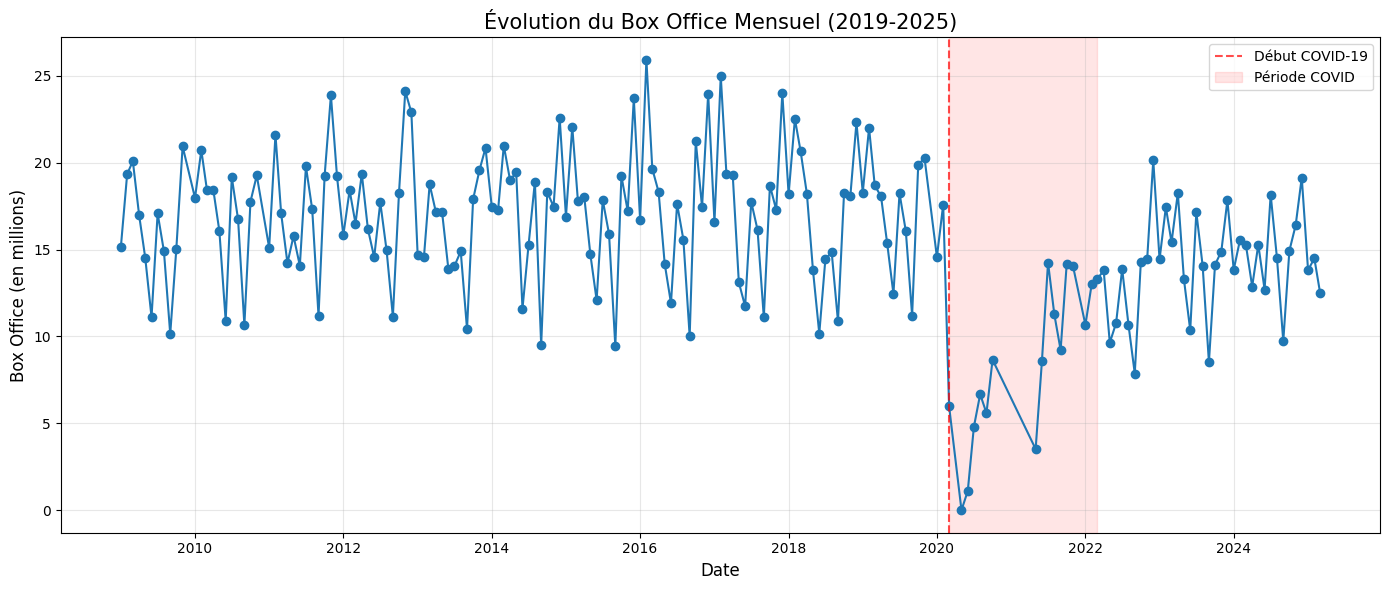

In [27]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))
plt.plot(df.index, df['box_office'], marker='o', linestyle='-')
plt.title('Évolution du Box Office Mensuel (2019-2025)', fontsize=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Box Office (en millions)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.axvline(x=pd.to_datetime('2020-03-01'), color='r', linestyle='--', alpha=0.7, label='Début COVID-19')
plt.axvspan(pd.to_datetime('2020-03-01'), pd.to_datetime('2022-03-01'), color='r', alpha=0.1, label='Période COVID')
plt.legend()
plt.tight_layout()
plt.show()

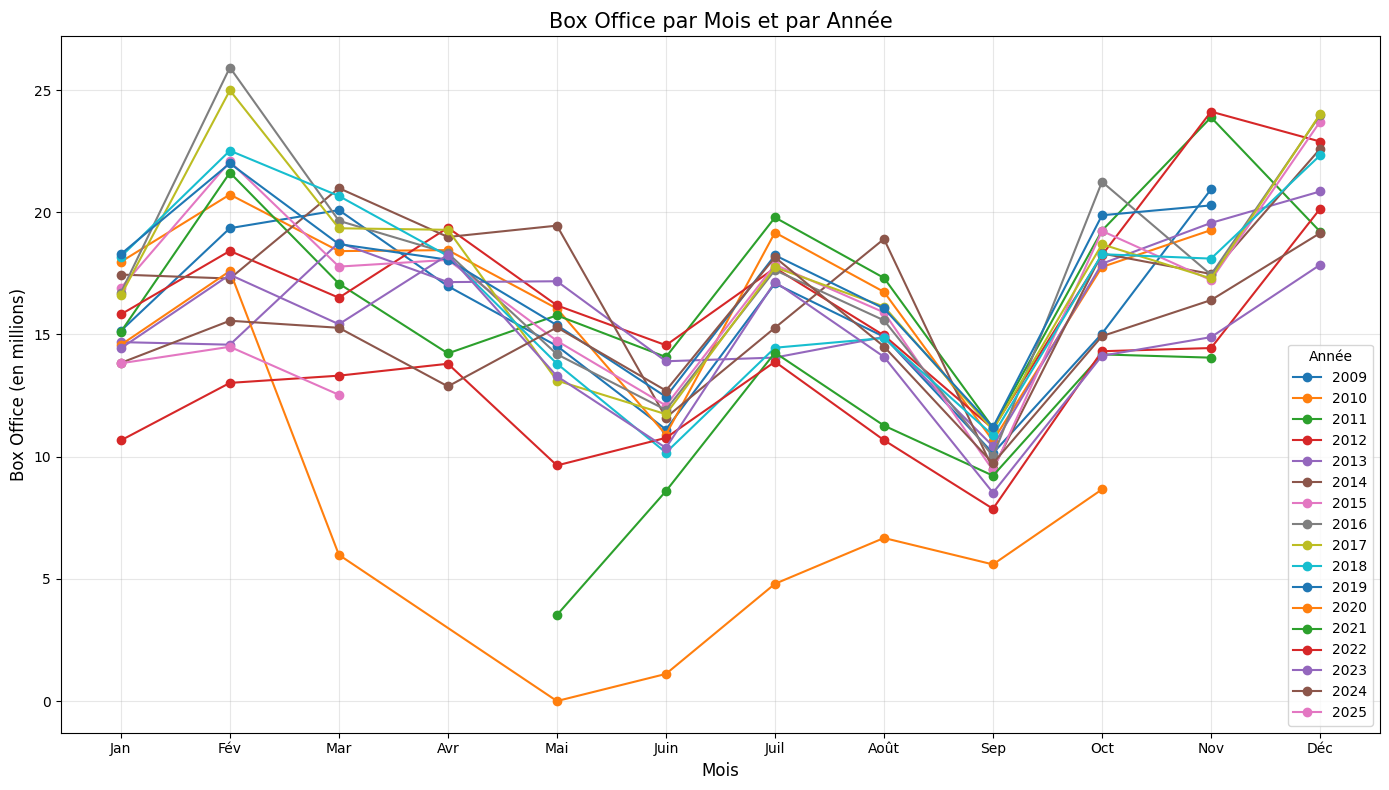

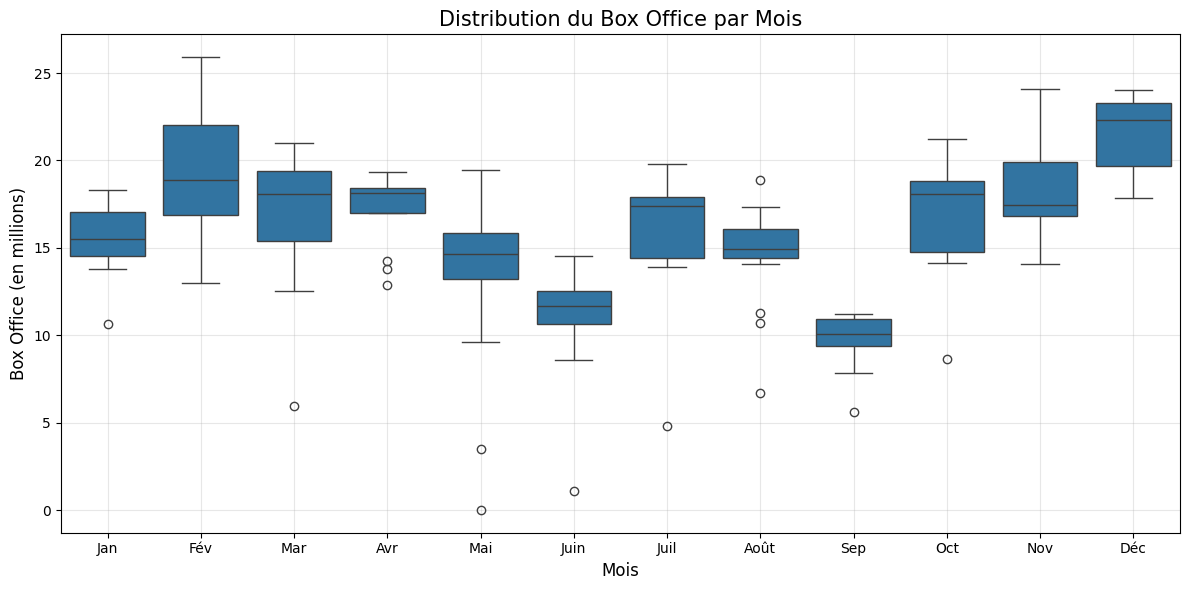

In [28]:
df['year'] = df.index.year
df['month_num'] = df.index.month
import seaborn as sns

# Graphique par année
plt.figure(figsize=(14, 8))
years = sorted(df['year'].unique())
for year in years:
    data_year = df[df['year'] == year]
    plt.plot(data_year['month_num'], data_year['box_office'], marker='o', linestyle='-', label=str(year))

plt.title('Box Office par Mois et par Année', fontsize=15)
plt.xlabel('Mois', fontsize=12)
plt.ylabel('Box Office (en millions)', fontsize=12)
plt.xticks(range(1, 13), ['Jan', 'Fév', 'Mar', 'Avr', 'Mai', 'Juin', 'Juil', 'Août', 'Sep', 'Oct', 'Nov', 'Déc'])
plt.grid(True, alpha=0.3)
plt.legend(title='Année')
plt.tight_layout()
plt.show()

# 3. Distribution des valeurs par boxplot pour voir les variations
plt.figure(figsize=(12, 6))
sns.boxplot(x='month_num', y='box_office', data=df)
plt.title('Distribution du Box Office par Mois', fontsize=15)
plt.xlabel('Mois', fontsize=12)
plt.ylabel('Box Office (en millions)', fontsize=12)
plt.xticks(range(12), ['Jan', 'Fév', 'Mar', 'Avr', 'Mai', 'Juin', 'Juil', 'Août', 'Sep', 'Oct', 'Nov', 'Déc'])
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

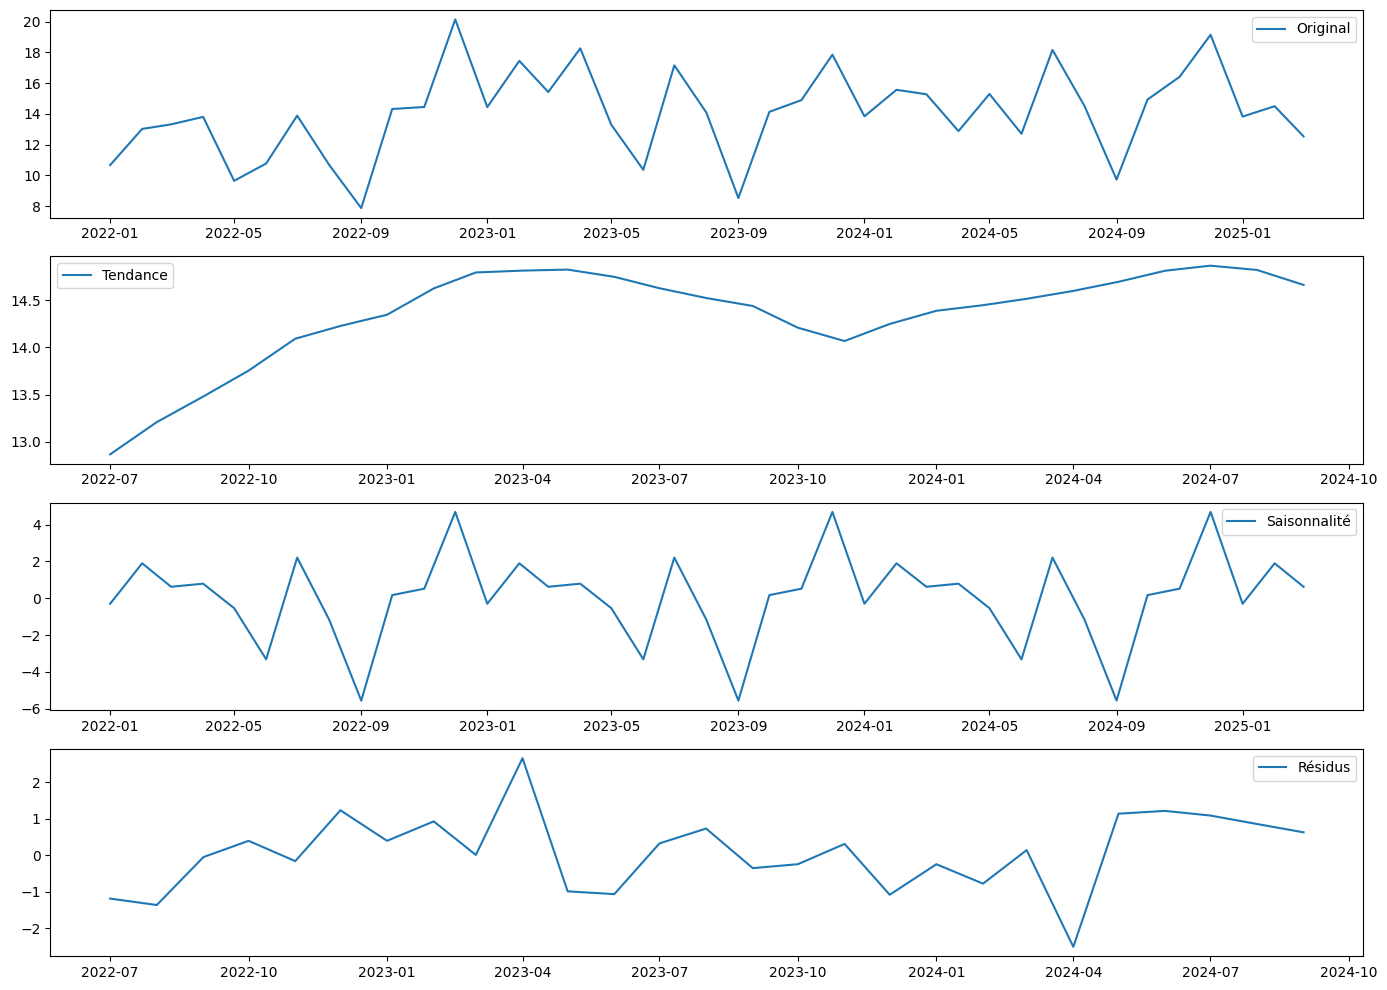

In [29]:
from statsmodels.tsa.seasonal import seasonal_decompose

full_idx = pd.date_range(start='2010-12-01', end='2025-03-01', freq='MS')
ts_full = df.reindex(full_idx)

# Interpolation simple pour remplir les valeurs manquantes (uniquement pour l'analyse)
ts_filled = ts_full.interpolate(method='linear')

# Décomposition de la série temporelle (après 2021 pour éviter l'impact majeur de la COVID)
post_covid = ts_filled.loc['2022-01-01':]
decomposition = seasonal_decompose(post_covid['box_office'], model='additive', period=12)

plt.figure(figsize=(14, 10))
plt.subplot(411)
plt.plot(post_covid.index, post_covid['box_office'], label='Original')
plt.legend()
plt.subplot(412)
plt.plot(decomposition.trend, label='Tendance')
plt.legend()
plt.subplot(413)
plt.plot(decomposition.seasonal, label='Saisonnalité')
plt.legend()
plt.subplot(414)
plt.plot(decomposition.resid, label='Résidus')
plt.legend()
plt.tight_layout()
plt.show()

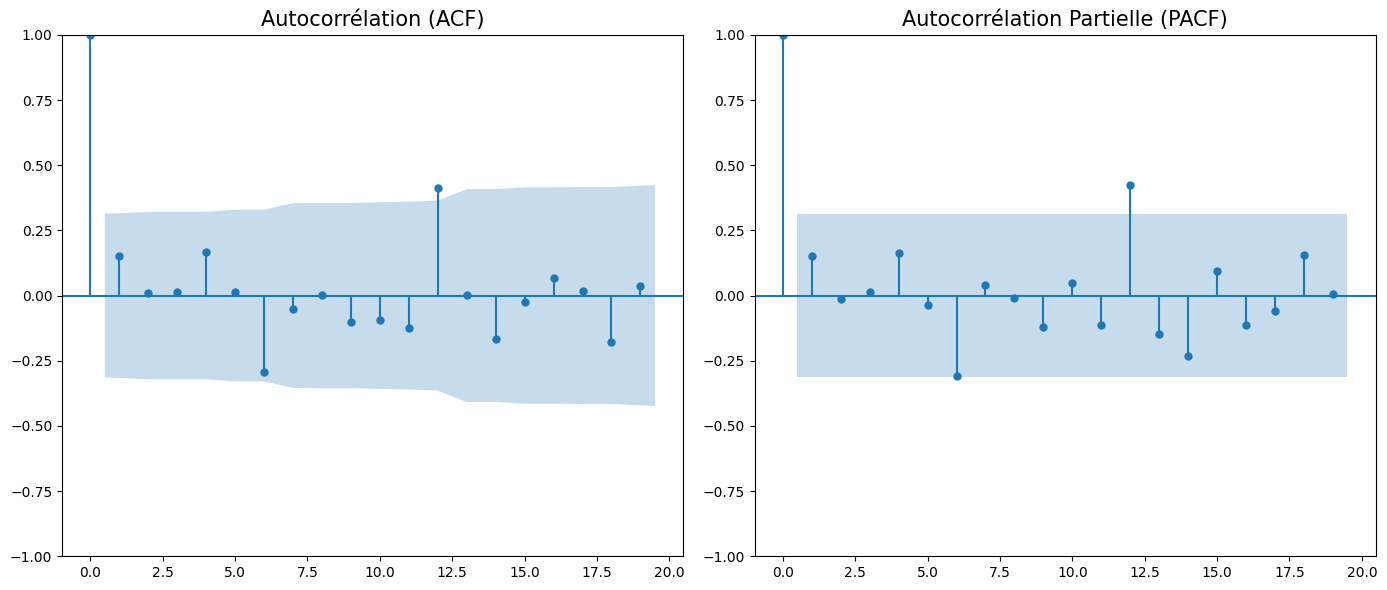

In [30]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize=(14, 6))
plt.subplot(121)
plot_acf(post_covid['box_office'].dropna(), lags=19, ax=plt.gca())
plt.title('Autocorrélation (ACF)', fontsize=15)
plt.subplot(122)
plot_pacf(post_covid['box_office'].dropna(), lags=19, ax=plt.gca())
plt.title('Autocorrélation Partielle (PACF)', fontsize=15)
plt.tight_layout()
plt.show()

In [31]:
train_data = ts_filled.loc['2022-01-01':'2024-12-01', 'box_office']
test_data = ts_filled.loc['2025-01-01':'2025-03-01', 'box_office']

In [32]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(train_data, 
                order=(1, 1, 1),           # (p,d,q) - parties non saisonnières
                seasonal_order=(1, 1, 1, 12),  # (P,D,Q,s) - partie saisonnière
                enforce_stationarity=False,
                enforce_invertibility=False)

results = model.fit(disp=False)
print(results.summary())

/home/utilisateur/Documents/Simplon/new_is_always_better/.venv/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


                                     SARIMAX Results                                      
Dep. Variable:                         box_office   No. Observations:                   36
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                 -18.987
Date:                            Mon, 14 Apr 2025   AIC                             47.975
Time:                                    14:32:13   BIC                             48.961
Sample:                                01-01-2022   HQIC                            45.846
                                     - 12-01-2024                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1854      0.549     -0.338      0.735      -1.261       0.890
ma.L1         -1.0000   8230.814   

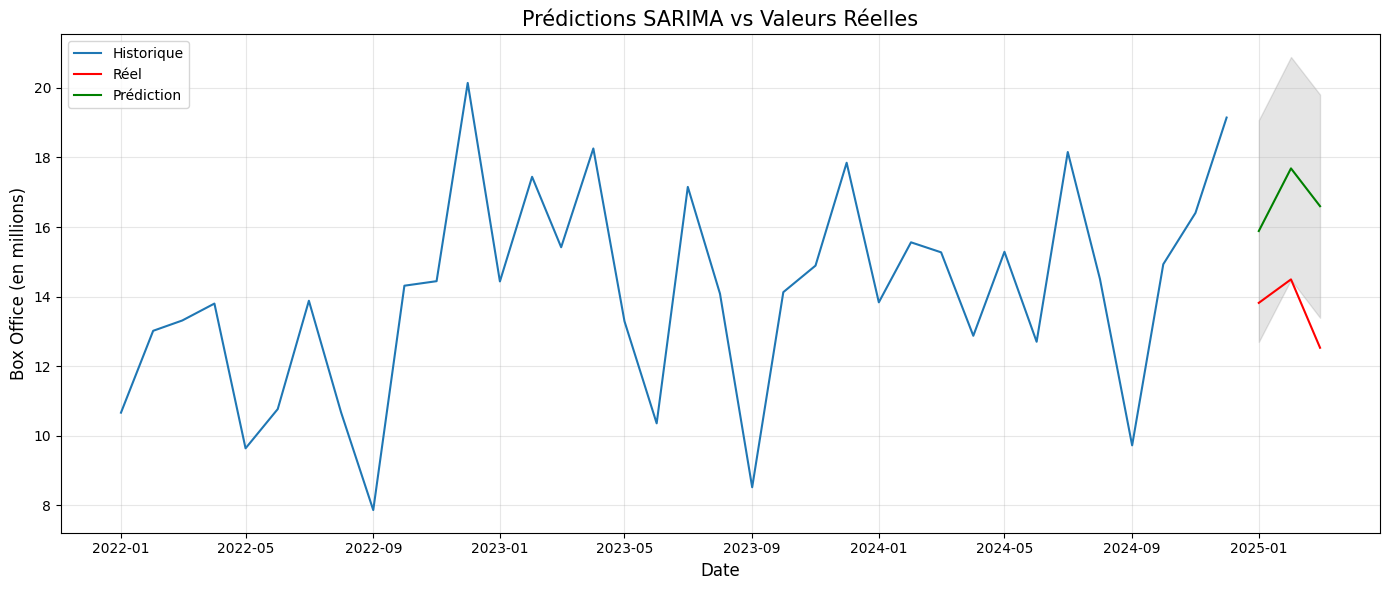

In [33]:
# Prédictions sur les données de test
pred = results.get_forecast(steps=len(test_data))
pred_ci = pred.conf_int()

# Visualisation des prédictions vs réelles
plt.figure(figsize=(14, 6))
plt.plot(train_data.index, train_data, label='Historique')
plt.plot(test_data.index, test_data, color='red', label='Réel')
plt.plot(test_data.index, pred.predicted_mean, color='green', label='Prédiction')
plt.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=0.1)
plt.title('Prédictions SARIMA vs Valeurs Réelles', fontsize=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Box Office (en millions)', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

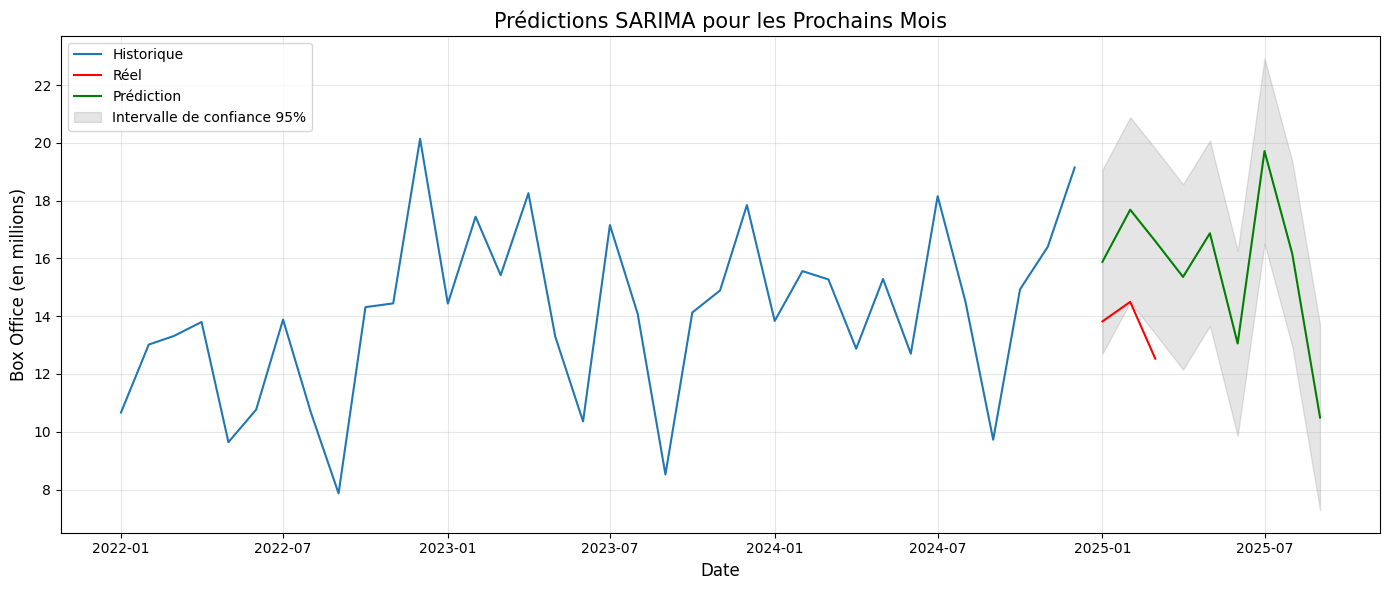

In [34]:
# Prédictions futures (6 mois)
future_steps = 6
future_pred = results.get_forecast(steps=len(test_data) + future_steps)
future_ci = future_pred.conf_int()

# Créer un index pour les prédictions futures
future_idx = pd.date_range(start='2025-01-01', periods=len(test_data) + future_steps, freq='MS')

# Visualisation incluant les prédictions futures
plt.figure(figsize=(14, 6))
plt.plot(train_data.index, train_data, label='Historique')
plt.plot(test_data.index, test_data, color='red', label='Réel')
plt.plot(future_idx, future_pred.predicted_mean, color='green', label='Prédiction')
plt.fill_between(future_idx,
                future_ci.iloc[:, 0],
                future_ci.iloc[:, 1], color='k', alpha=0.1, label='Intervalle de confiance 95%')
plt.title('Prédictions SARIMA pour les Prochains Mois', fontsize=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Box Office (en millions)', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [35]:
df_modified = df.copy()

# Identifier la période COVID
covid_start = pd.to_datetime('2020-03-01')
covid_end = pd.to_datetime('2022-03-01')
covid_mask = (df.index >= covid_start) & (df.index <= covid_end)

In [36]:
def check_missing_dates(df, freq='MS'):
    """
    Vérifie les dates manquantes dans une dataframe avec un index temporel.
    
    Paramètres:
    - df: DataFrame avec un index temporel
    - freq: fréquence des données ('MS' pour début de mois)
    
    Retourne:
    - DataFrame avec les dates manquantes et leurs indices
    """
    # S'assurer que l'index est bien un DatetimeIndex
    if not isinstance(df.index, pd.DatetimeIndex):
        raise ValueError("L'index du DataFrame doit être un DatetimeIndex")
    
    # Créer un index complet sur la période
    full_idx = pd.date_range(start=df.index.min(), end=df.index.max(), freq=freq)
    
    # Trouver les dates manquantes
    missing_dates = full_idx.difference(df.index)
    
    # Afficher les résultats
    print(f"Période analysée: {df.index.min().strftime('%Y-%m')} à {df.index.max().strftime('%Y-%m')}")
    print(f"Nombre total de dates attendues: {len(full_idx)}")
    print(f"Nombre de dates présentes: {len(df.index)}")
    print(f"Nombre de dates manquantes: {len(missing_dates)}")
    
    if len(missing_dates) > 0:
        print("\nDates manquantes:")
        for date in missing_dates:
            print(f"- {date.strftime('%Y-%m')}")
    
    return missing_dates

check_missing_dates(df_modified)

Période analysée: 2009-01 à 2025-03
Nombre total de dates attendues: 195
Nombre de dates présentes: 184
Nombre de dates manquantes: 11

Dates manquantes:
- 2009-12
- 2010-12
- 2019-12
- 2020-04
- 2020-11
- 2020-12
- 2021-01
- 2021-02
- 2021-03
- 2021-04
- 2021-12


DatetimeIndex(['2009-12-01', '2010-12-01', '2019-12-01', '2020-04-01',
               '2020-11-01', '2020-12-01', '2021-01-01', '2021-02-01',
               '2021-03-01', '2021-04-01', '2021-12-01'],
              dtype='datetime64[ns]', freq=None)

In [37]:
def estimate_normal_value(date, df):
    month = date.month
    # Collecter les valeurs des mêmes mois des années précédentes (2017-2019)
    values = []
    for year in range(2017, 2020):
        comparable_date = pd.to_datetime(f"{year}-{month:02d}-01")
        if comparable_date in df.index and not pd.isna(df.loc[comparable_date, 'box_office']):
            values.append(df.loc[comparable_date, 'box_office'])
    
    # Si nous avons des valeurs, calculer la moyenne
    if values:
        return np.mean(values)
    else:
        return None

# Appliquer le remplacement pour la période COVID
for date in df.loc[covid_mask].index:
    normal_value = estimate_normal_value(date, df)
    if normal_value is not None:
        df_modified.loc[date, 'box_office'] = normal_value

In [38]:
# df_filled = fill_missing_dates(df.drop(['month_num','year'], axis=1), method='seasonal_mean')
# df_filled.reset_index(inplace=True)
# table = pa.Table.from_pandas(df_filled)
# pq.write_table(table, 'nationnal_afluence_filled.parquet')

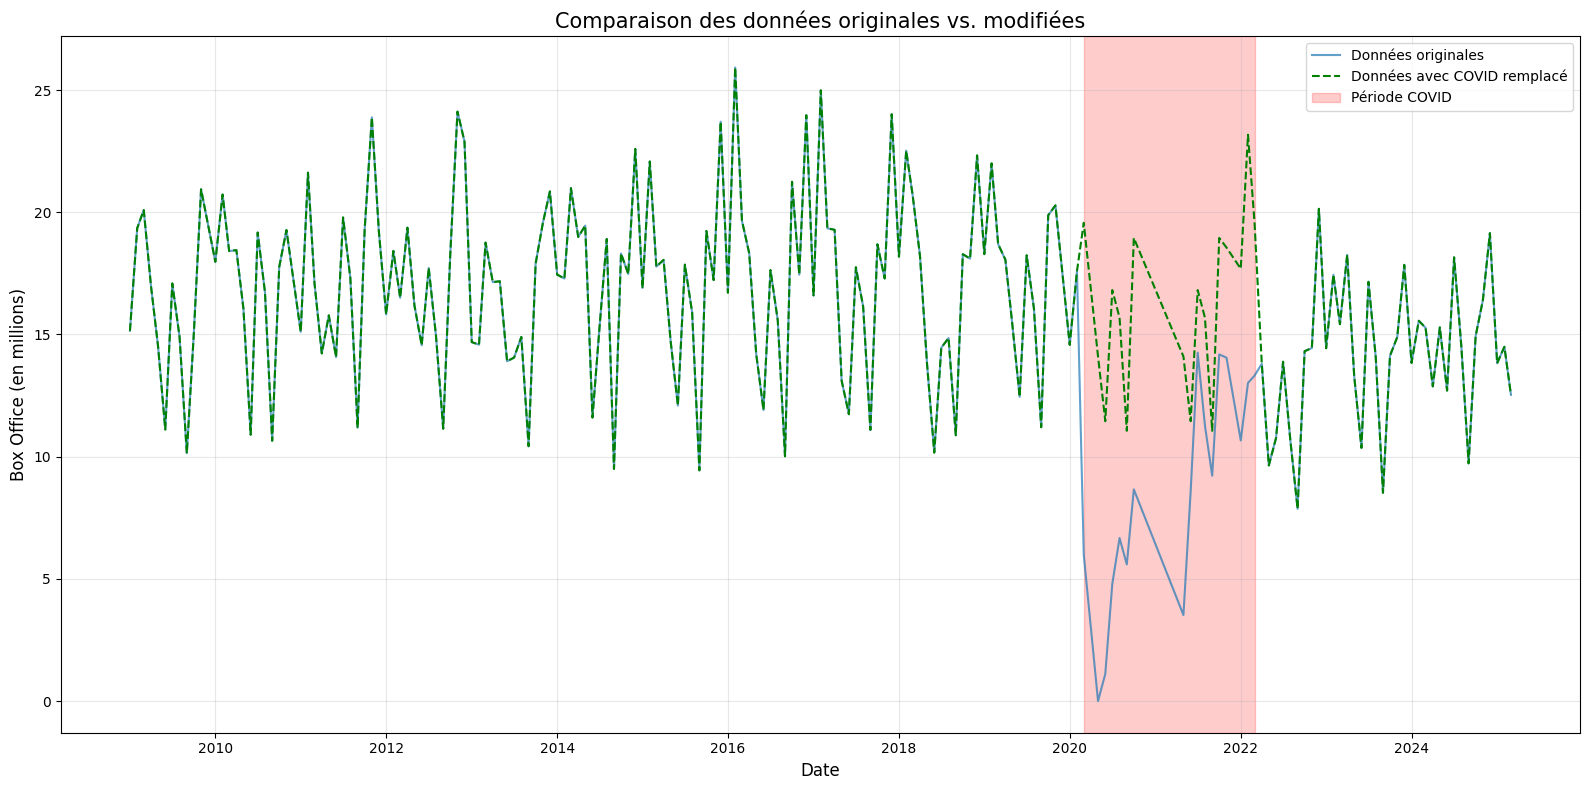

In [39]:
plt.figure(figsize=(16, 8))
plt.plot(df.index, df['box_office'], label='Données originales', alpha=0.7)
plt.plot(df_modified.index, df_modified['box_office'], label='Données avec COVID remplacé', 
         color='green', linestyle='--')
plt.title('Comparaison des données originales vs. modifiées', fontsize=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Box Office (en millions)', fontsize=12)
plt.axvspan(covid_start, covid_end, color='red', alpha=0.2, label='Période COVID')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

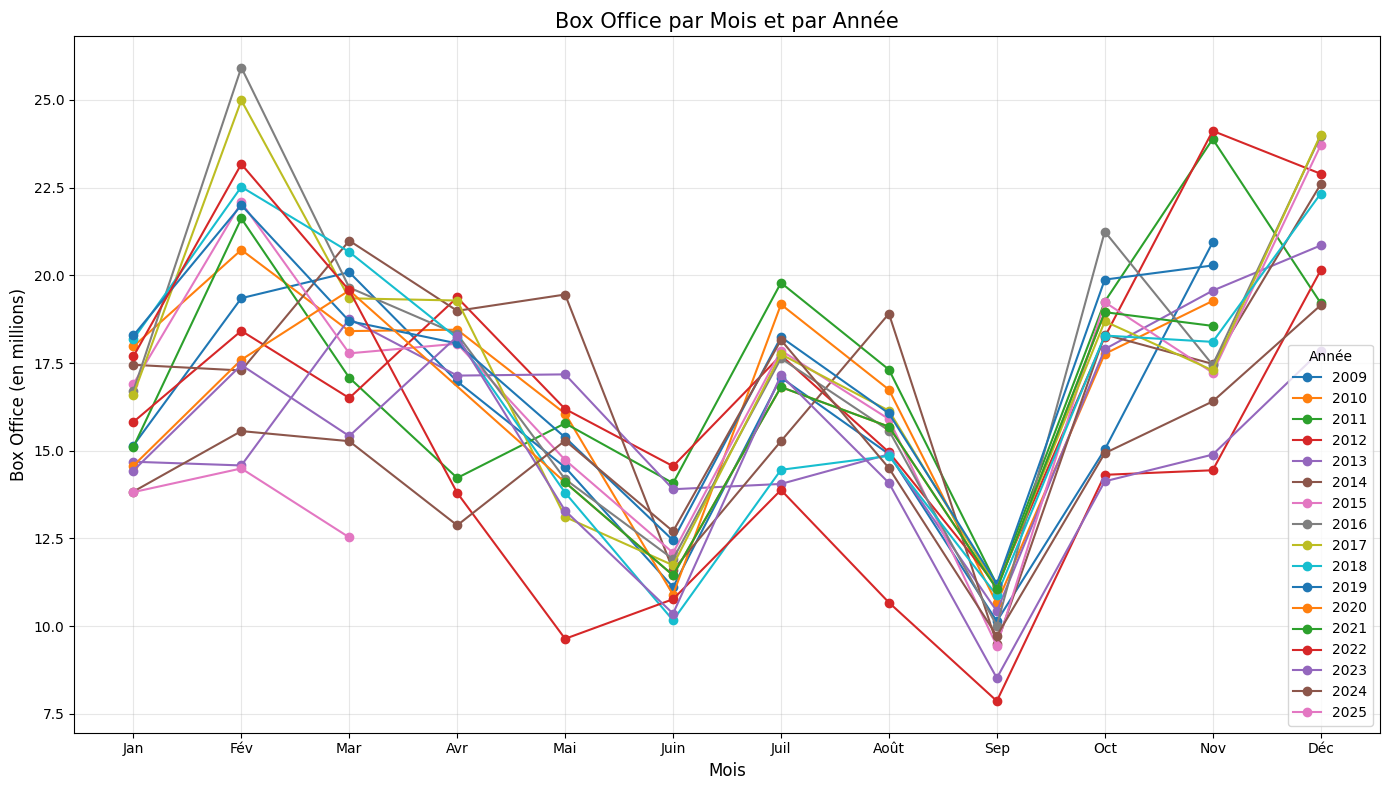

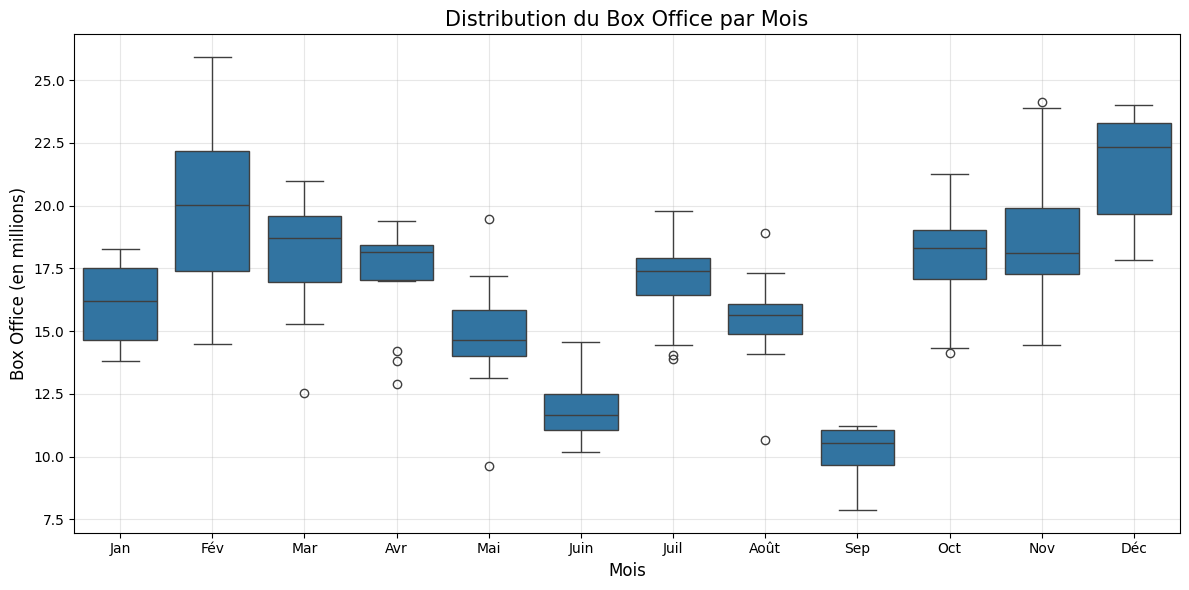

In [40]:
df_modified['year'] = df_modified.index.year
df_modified['month_num'] = df_modified.index.month
import seaborn as sns

# Graphique par année
plt.figure(figsize=(14, 8))
years = sorted(df_modified['year'].unique())
for year in years:
    data_year = df_modified[df_modified['year'] == year]
    plt.plot(data_year['month_num'], data_year['box_office'], marker='o', linestyle='-', label=str(year))

plt.title('Box Office par Mois et par Année', fontsize=15)
plt.xlabel('Mois', fontsize=12)
plt.ylabel('Box Office (en millions)', fontsize=12)
plt.xticks(range(1, 13), ['Jan', 'Fév', 'Mar', 'Avr', 'Mai', 'Juin', 'Juil', 'Août', 'Sep', 'Oct', 'Nov', 'Déc'])
plt.grid(True, alpha=0.3)
plt.legend(title='Année')
plt.tight_layout()
plt.show()

# 3. Distribution des valeurs par boxplot pour voir les variations
plt.figure(figsize=(12, 6))
sns.boxplot(x='month_num', y='box_office', data=df_modified)
plt.title('Distribution du Box Office par Mois', fontsize=15)
plt.xlabel('Mois', fontsize=12)
plt.ylabel('Box Office (en millions)', fontsize=12)
plt.xticks(range(12), ['Jan', 'Fév', 'Mar', 'Avr', 'Mai', 'Juin', 'Juil', 'Août', 'Sep', 'Oct', 'Nov', 'Déc'])
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [41]:
train_data.isna().count()

np.int64(36)

In [42]:
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import mean_squared_error, mean_absolute_error
train_data = df_modified.loc[:'2024-12-01', 'box_office']
test_data = df_modified.loc['2025-01-01':, 'box_office']

# Fonction pour évaluer un modèle SARIMA avec des paramètres donnés
def evaluate_sarima_model(train, test, order, seasonal_order):
    try:
        # Ajuster le modèle
        model = SARIMAX(train, order=order, seasonal_order=seasonal_order, 
                      enforce_stationarity=False, enforce_invertibility=False)
        model_fit = model.fit(disp=False)
        
        # Faire des prédictions
        predictions = model_fit.forecast(len(test))
        
        # Calculer les métriques d'erreur
        mse = mean_squared_error(test, predictions)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(test, predictions)
        
        return {'order': order, 'seasonal_order': seasonal_order, 
                'rmse': rmse, 'mae': mae, 'model': model_fit}
    except:
        return None

# Définir les paramètres à tester
p_values = [0, 1, 2]
d_values = [0, 1]
q_values = [0, 1, 2]
P_values = [0, 1]
D_values = [0, 1]
Q_values = [0, 1]
s_values = [12]  # Période saisonnière fixée à 12 mois

# Grille de recherche limitée (pour éviter d'exécuter trop de modèles)
# Vous pouvez augmenter les combinaisons si nécessaire
param_combinations = []
for p in p_values:
    for d in d_values:
        for q in q_values:
            for P in P_values:
                for D in D_values:
                    for Q in Q_values:
                        for s in s_values:
                            param_combinations.append((p, d, q, P, D, Q, s))

# # Limiter le nombre de combinaisons pour des raisons de temps d'exécution
# # En pratique, vous pourriez vouloir tester toutes les combinaisons
# np.random.seed(42)
# if len(param_combinations) > 20:
#     param_combinations = np.random.choice(param_combinations, size=20, replace=False)

# Évaluer chaque combinaison de paramètres
results = []
for params in param_combinations:
    p, d, q, P, D, Q, s = params
    order = (p, d, q)
    seasonal_order = (P, D, Q, s)
    result = evaluate_sarima_model(train_data, test_data, order, seasonal_order)
    if result is not None:
        results.append(result)

# Trier les résultats par RMSE
results.sort(key=lambda x: x['rmse'])

# Afficher les meilleurs modèles
print("\nMeilleurs modèles SARIMA:")
for i, result in enumerate(results[:5]):
    print(f"{i+1}. SARIMA{result['order']}x{result['seasonal_order']} - RMSE: {result['rmse']:.4f}, MAE: {result['mae']:.4f}")



Meilleurs modèles SARIMA:
1. SARIMA(1, 0, 0)x(1, 0, 0, 12) - RMSE: 1.4091, MAE: 1.0895
2. SARIMA(1, 0, 1)x(1, 0, 0, 12) - RMSE: 1.4101, MAE: 1.0576
3. SARIMA(0, 0, 1)x(1, 0, 0, 12) - RMSE: 1.4226, MAE: 1.0900
4. SARIMA(1, 0, 2)x(1, 0, 0, 12) - RMSE: 1.4258, MAE: 1.1276
5. SARIMA(0, 0, 0)x(1, 0, 0, 12) - RMSE: 1.4471, MAE: 1.1318


In [43]:
best_model = results[0]['model']
print(f"\nMeilleur modèle sélectionné: SARIMA{results[0]['order']}x{results[0]['seasonal_order']}")
print(best_model.summary())


Meilleur modèle sélectionné: SARIMA(1, 0, 0)x(1, 0, 0, 12)
                                     SARIMAX Results                                      
Dep. Variable:                         box_office   No. Observations:                  181
Model:             SARIMAX(1, 0, 0)x(1, 0, 0, 12)   Log Likelihood                -432.293
Date:                            Mon, 14 Apr 2025   AIC                            870.587
Time:                                    14:33:35   BIC                            879.959
Sample:                                         0   HQIC                           874.390
                                            - 181                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0408      0.066      0.618      0.537

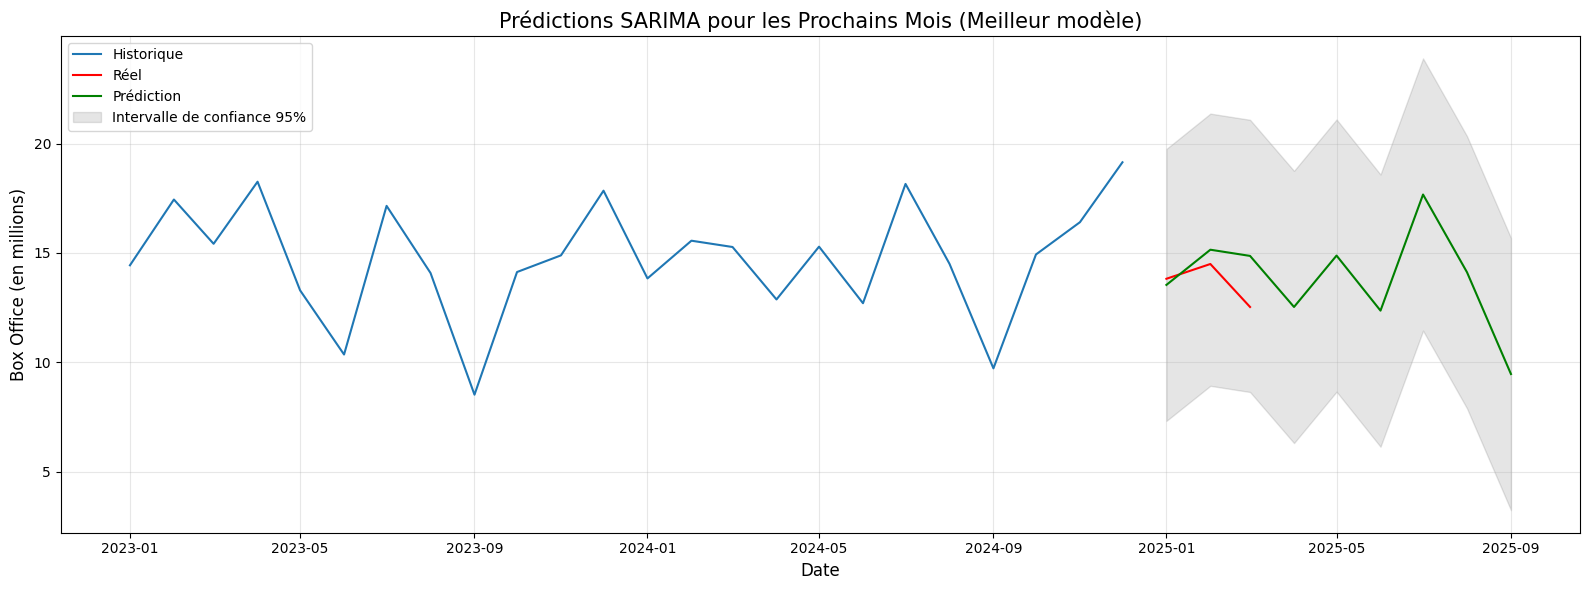

In [44]:
# Prédictions futures (6 mois)
future_steps = 6
future_index = pd.date_range(start=test_data.index[-1] + pd.DateOffset(months=1), periods=future_steps, freq='MS')
future_pred = best_model.get_forecast(steps=len(test_data) + future_steps)
future_ci = future_pred.conf_int()

# Créer un index pour les prédictions futures
full_pred_index = pd.date_range(start=test_data.index[0], periods=len(test_data) + future_steps, freq='MS')

# Visualisation incluant les prédictions futures
plt.figure(figsize=(16, 6))
plt.plot(train_data.index[-24:], train_data[-24:], label='Historique')
plt.plot(test_data.index, test_data, color='red', label='Réel')
plt.plot(full_pred_index, future_pred.predicted_mean, color='green', label='Prédiction')
plt.fill_between(full_pred_index,
                future_ci.iloc[:, 0],
                future_ci.iloc[:, 1], color='k', alpha=0.1, label='Intervalle de confiance 95%')
plt.title('Prédictions SARIMA pour les Prochains Mois (Meilleur modèle)', fontsize=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Box Office (en millions)', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [45]:
best_order = results[0]['order']      
best_seasonal_order = results[0]['seasonal_order']

# 1. Entraîner le modèle sur l'ensemble complet des données normalisées (df_modified)
model = SARIMAX(df_modified['box_office'], 
                order=best_order, 
                seasonal_order=best_seasonal_order,
                enforce_stationarity=False, 
                enforce_invertibility=False)
model_fit = model.fit(disp=False)
print("Modèle SARIMA entraîné avec succès sur les données complètes")
print(f"Paramètres: SARIMA{best_order}x{best_seasonal_order}")

Modèle SARIMA entraîné avec succès sur les données complètes
Paramètres: SARIMA(1, 0, 0)x(1, 0, 0, 12)


In [46]:
last_date = df_modified.index.max()
next_months = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=2, freq='MS')

predictions = model_fit.get_forecast(steps=2)
pred_mean = predictions.predicted_mean
pred_ci = predictions.conf_int()

forecast_df = pd.DataFrame({'box_office':pred_mean,
                            'month': next_months,
                            'lower_ci': pred_ci.iloc[:, 0],
                            'upper_ci': pred_ci.iloc[:, 1]})
forecast_df.set_index('month', inplace=True)

print("\nPrédictions pour les deux prochains mois:")
for date, value in zip(forecast_df.index, forecast_df['box_office']):
    lower = forecast_df.loc[date, 'lower_ci']
    upper = forecast_df.loc[date, 'upper_ci']
    print(f"{date.strftime('%Y-%m')}: {value:.2f} millions [IC 95%: {lower:.2f} - {upper:.2f}]")


Prédictions pour les deux prochains mois:
2025-04: 12.42 millions [IC 95%: 6.25 - 18.59]
2025-05: 14.86 millions [IC 95%: 8.68 - 21.04]


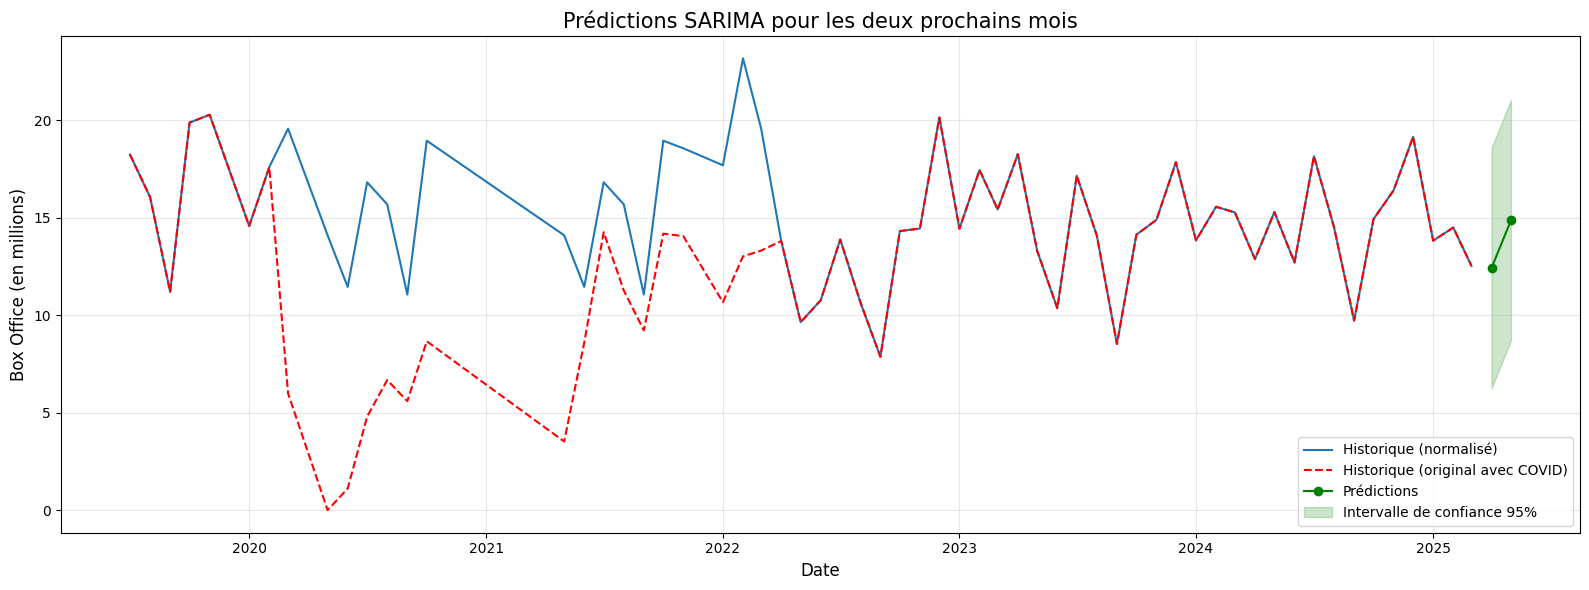

In [47]:
plt.figure(figsize=(16, 6))
plt.plot(df_modified.index[-60:], df_modified['box_office'][-60:], label='Historique (normalisé)')
if 'box_office' in df_to_azure.columns:
    plt.plot(df_to_azure.index[-60:], df_to_azure['box_office'][-60:], 'r--', label='Historique (original avec COVID)')
plt.plot(forecast_df.index, forecast_df['box_office'], 'g-o', label='Prédictions')
plt.fill_between(forecast_df.index,
                forecast_df['lower_ci'],
                forecast_df['upper_ci'], color='g', alpha=0.2, label='Intervalle de confiance 95%')
plt.title('Prédictions SARIMA pour les deux prochains mois', fontsize=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Box Office (en millions)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

In [48]:
df_to_azure['is_prediction']=0
forecast_df['is_prediction']=1
forecast_df.drop(['lower_ci', 'upper_ci'], axis=1, inplace=True)
df_to_azure = pd.concat([df_to_azure, forecast_df])

In [49]:
df_to_azure

,box_office,is_prediction
month,,
2009-01-01,15.148333,0
2009-02-01,19.348000,0
2009-03-01,20.087500,0
2009-04-01,16.975000,0
2009-05-01,14.528333,0
...,...,...
2025-01-01,13.820000,0
2025-02-01,14.495000,0
2025-03-01,12.530000,0


In [50]:
# from azure.ai.ml.entities import Data
# from azure.ai.ml.constants import AssetTypes
# import pyarrow as pa
# import pyarrow.parquet as pq

# df_to_blob = df_to_azure
# path = 'national_affluence_with_predict.parquet'
# file_name= "cncAffluence"
# version = "2.0.0" # Ici je me dit qu'on pourait se mettre d'accord sur lesquels sont les notres, genres 2.truc c'est vic, 3.truc ludi, 4.truc raouf ?
# description = "Pour entrainer les modèles"

# table = pa.Table.from_pandas(df_to_blob)
# pq.write_table(table, path)
# new_data_asset = Data(
#     path=path,
#     type=AssetTypes.URI_FILE,
#     name=file_name, 
#     version=version,           
#     description=description
# )

# ml_client.data.create_or_update(new_data_asset)

In [53]:
def fill_missing_dates(df):
    """
    Complète les dates manquantes dans une dataframe en suivant la logique :
    - Moyenne du même mois des années Y-1 et Y+1 (ou Y-2/Y+2 si manquantes)
    - Sinon moyenne du même mois toutes années confondues
    - Sinon interpolation
    """
    df_filled = df.copy()
    missing_dates = check_missing_dates(df)

    # Ajouter les dates manquantes avec NaN
    for date in missing_dates:
        if date not in df_filled.index:
            df_filled.loc[date] = np.nan

    df_filled = df_filled.sort_index()

    for date in missing_dates:
        year = date.year
        month = date.month

        values = []

        # Chercher année précédente ou Y-2
        prev_date = pd.Timestamp(year - 1, month, 1)
        if prev_date in df.index:
            values.append(df.loc[prev_date, 'box_office'])
        else:
            prev_alt = pd.Timestamp(year - 2, month, 1)
            if prev_alt in df.index:
                values.append(df.loc[prev_alt, 'box_office'])

        # Chercher année suivante ou Y+2
        next_date = pd.Timestamp(year + 1, month, 1)
        if next_date in df.index:
            values.append(df.loc[next_date, 'box_office'])
        else:
            next_alt = pd.Timestamp(year + 2, month, 1)
            if next_alt in df.index:
                values.append(df.loc[next_alt, 'box_office'])

        if values:
            df_filled.loc[date, 'box_office'] = np.mean(values)
            print(f"{date.strftime('%Y-%m')} → Moyenne années proches (±2): {df_filled.loc[date, 'box_office']:.2f}")
        else:
            # Moyenne tous les mêmes mois (n'importe quelle année)
            same_month_values = df[df.index.month == month]['box_office']
            if not same_month_values.empty:
                df_filled.loc[date, 'box_office'] = same_month_values.mean()
                print(f"{date.strftime('%Y-%m')} → Moyenne des mêmes mois: {df_filled.loc[date, 'box_office']:.2f}")
            else:
                # Interpolation si vraiment rien
                df_filled = df_filled.sort_index().interpolate(method='linear')
                print(f"{date.strftime('%Y-%m')} → Interpolé: {df_filled.loc[date, 'box_office']:.2f}")

    return df_filled


In [61]:
df_filled_to_azure = fill_missing_dates(df_to_azure)

Période analysée: 2009-01 à 2025-05
Nombre total de dates attendues: 197
Nombre de dates présentes: 186
Nombre de dates manquantes: 11

Dates manquantes:
- 2009-12
- 2010-12
- 2019-12
- 2020-04
- 2020-11
- 2020-12
- 2021-01
- 2021-02
- 2021-03
- 2021-04
- 2021-12
2009-12 → Moyenne années proches (±2): 19.21
2010-12 → Moyenne années proches (±2): 19.21
2019-12 → Moyenne années proches (±2): 22.32
2020-04 → Moyenne années proches (±2): 15.93
2020-11 → Moyenne années proches (±2): 17.16
2020-12 → Moyenne années proches (±2): 21.23
2021-01 → Moyenne années proches (±2): 12.62
2021-02 → Moyenne années proches (±2): 15.31
2021-03 → Moyenne années proches (±2): 9.65
2021-04 → Moyenne années proches (±2): 15.93
2021-12 → Moyenne années proches (±2): 20.14


In [57]:
df_filled_to_azure.head(12)

,box_office,is_prediction
month,,
2009-01-01,15.148333,0.0
2009-02-01,19.348000,0.0
2009-03-01,20.087500,0.0
2009-04-01,16.975000,0.0
2009-05-01,14.528333,0.0
2009-06-01,11.110000,0.0
2009-07-01,17.085000,0.0
2009-08-01,14.905000,0.0
2009-09-01,10.140000,0.0


In [ ]:
box_office_by_year = {"2010" : 206500000,
 "2009" : 201140000,
 "2008" : 190100000,
 "2007" : 177730000,
 "2006" : 188710000,
 "2005" : 174150000,
 "2004" : 195380000,
 "2003" : 173460000,
 "2002" : 184180000,
 "2001" : 187220000,
 "2000" : 165530000,
 "1999" : 153570000,
 "1998" : 170570000,
 "1997" : 149020000,
 "1996" : 136740000,
 "1995" : 130240000,
 "1994" : 124420000,
 "1993" : 132700000,
 "1992" : 116000000,
 "1991" : 117500000,
 "1990" : 121900000,
 "1989" : 120900000
}

def create_synthetic_years(df, box_office_by_year):
    df = df.copy()

    # 1. Distribution mensuelle moyenne sur 2009 et 2010
    reference_years = [2009, 2010]
    ref_df = df[df.index.year.isin(reference_years)]
    monthly_avg = ref_df.groupby(ref_df.index.month)['box_office'].mean()
    monthly_proportions = monthly_avg / ((int(box_office_by_year["2009"])+int(box_office_by_year["2010"]))/2)  # Normalisation

    # 2. Générer les mois manquants
    synthetic_rows = []
    for year_str, total in box_office_by_year.items():
        year = int(year_str)
        if year >= min(reference_years):  # On ne génère que pour les années manquantes
            continue
        for month in range(1, 13):
            date = pd.Timestamp(year, month, 1)
            estimated_value = total * monthly_proportions[month]
            synthetic_rows.append({
                'month': date,
                'box_office': estimated_value,
                'is_prediction': 0
            })

    # 3. Création d’un dataframe et concat avec df existant
    df_synthetic = pd.DataFrame(synthetic_rows).set_index('month')
    df_combined = pd.concat([df, df_synthetic]).sort_index()

    # Remplir is_prediction manquant à 0 (pour les vraies données)
    df_combined['is_prediction'] = df_combined['is_prediction'].fillna(0.0)

    return df_combined

df_filled_to_azure = create_synthetic_years(df_filled_to_azure, box_office_by_year)


In [67]:
df_filled_to_azure.head(140)

,box_office,is_prediction
month,,
1989-01-01,9.822903,1.0
1989-02-01,11.884946,1.0
1989-03-01,11.417790,1.0
1989-04-01,10.506531,1.0
1989-05-01,9.071718,1.0
...,...,...
2000-04-01,14.384997,1.0
2000-05-01,12.420525,1.0
2000-06-01,8.937000,1.0


In [68]:
from azure.ai.ml.entities import Data
from azure.ai.ml.constants import AssetTypes
import pyarrow as pa
import pyarrow.parquet as pq

df_to_blob = df_filled_to_azure
path = 'national_affluence_with_predict.parquet'
file_name= "cncAffluence"
version = "2.0.1" # Ici je me dit qu'on pourait se mettre d'accord sur lesquels sont les notres, genres 2.truc c'est vic, 3.truc ludi, 4.truc raouf ?
description = "fill values"

table = pa.Table.from_pandas(df_to_blob)
pq.write_table(table, path)
new_data_asset = Data(
    path=path,
    type=AssetTypes.URI_FILE,
    name=file_name, 
    version=version,           
    description=description
)

ml_client.data.create_or_update(new_data_asset)

Uploading national_affluence_with_predict.parquet (< 1 MB): 100%|██████████| 10.6k/10.6k [00:00<00:00, 587kB/s]




Data({'path': 'azureml://subscriptions/72eb7803-e874-44cb-b6d9-33f2fa3eb88c/resourcegroups/vpoutotrg/workspaces/mlstudio-groupe4/datastores/workspaceblobstore/paths/LocalUpload/4f3dce15a585cd009f0d90fb6a23aca7/national_affluence_with_predict.parquet', 'skip_validation': False, 'mltable_schema_url': None, 'referenced_uris': None, 'type': 'uri_file', 'is_anonymous': False, 'auto_increment_version': False, 'auto_delete_setting': None, 'name': 'cncAffluence', 'description': 'fill values', 'tags': {}, 'properties': {}, 'print_as_yaml': False, 'id': '/subscriptions/72eb7803-e874-44cb-b6d9-33f2fa3eb88c/resourceGroups/vpoutotrg/providers/Microsoft.MachineLearningServices/workspaces/mlstudio-groupe4/data/cncAffluence/versions/2.0.1', 'Resource__source_path': '', 'base_path': '/home/utilisateur/Documents/Simplon/new_is_always_better/modelisation/victor', 'creation_context': <azure.ai.ml.entities._system_data.SystemData object at 0x780d690670e0>, 'serialize': <msrest.serialization.Serializer obje